In [13]:
# https://towardsdatascience.com/how-to-solve-constrained-optimization-problem-the-interior-point-methods-1733095f9eb5
# Interier point method

import numpy as np
import matplotlib.pyplot as plt
def f(x):
    '''Function to be minimized'''
    return (x[0]-5)**2 + (x[1]-6)**2

def g(x, t):
    '''Gradient of f(x) + 1/t * ϕ(x)'''

    x1, x2 = x
    
    dcdx1 = []
    # dcdx1.append(2*x1 / (x1**2 - 4))
    # dcdx1.append(-np.exp(-x1) / (np.exp(-x1) - x2))
    # dcdx1.append(1 / (x1 + 2*x2 - 4))
    dcdx1.append(-1 / (-x1))
    dcdx1.append(0 / (-x2))
    
    dcdx2 = []
    # dcdx2.append(0 / (x1**2 - 4))
    # dcdx2.append(-1 / (np.exp(-x1) - x2))
    # dcdx2.append(2 / (x1 + 2*x2 - 4))
    dcdx2.append(0 / (-x1))
    dcdx2.append(-1 / (-x2))
    
    dthetadx1 = 0
    dthetadx2 = 0
    for a, b in zip(dcdx1, dcdx2):
        dthetadx1 -= a
        dthetadx2 -= b
    
    grad = np.zeros(2)
    grad[0] = 2 * (x1-5) + 1/t * dthetadx1
    grad[1] = 2 * (x2-6) + 1/t * dthetadx2
    
    return grad

def H(x, t):
    '''Hessian of f(x) + 1/t * ϕ(x)'''
    
    x1, x2 = x
    
    terms = []
    terms.append(x1**2 - 4)
    terms.append(np.exp(-x1) - x2)
    terms.append(x1 + 2*x2 - 4)
    
    hess = np.zeros((2, 2))
    # hess[0][0] = 2 - 1/t * ((-2 * x1**2 - 8)/(terms[0]**2) - \
    #                         (x2 * np.exp(-x1))/(terms[1]**2) - \
    #                         1/(terms[2]**2))
    
    # hess[0][1] = -1/t * (-np.exp(-x1)/(terms[1]**2) - \
    #                      2/(terms[2]**2))
    
    # hess[1][0] = hess[0][1]
    # hess[1][1] = 2 - 1/t * (-1/(terms[1]**2) - 4/(terms[2]**2))
    hess[0][0] = 2 
    
    hess[0][1] = 0
    
    hess[1][0] = hess[0][1]
    hess[1][1] = 2 
    
    return hess

In [14]:
def BarrierMethod(x_init, m, t, nu=0.01, tol_barrier=1e-5, tol_newton = 1e-5, max_iter=1000):
    '''Main algorithm for Barrier Method'''
    
    x = x_init               # store initial value
    xs = [x]                 # initialize tabulation of x for each iteration
    fs = [f(x)]              # initialize tabulation of function value at x
    duality_gap = [m/t]      # initialize tabulation of duality gap
    k = 0                    # number of iterations
    print(f'Initial condition: x = {x}, f(x) = {fs[k]:.4f}\n')

    # loop until stopping criterion is met
    while m / t > tol_barrier:
        # centering step: Newton Algorithm
        i = 0
        d = np.array([[1], [1]])
        while np.linalg.norm(d) > tol_newton and i < max_iter:
            gx = g(x, t)
            Hx = H(x, t)
            d = -np.dot(np.linalg.inv(Hx), gx)
            x = x + d
            xs.append(x)
            i += 1
        
        # update parameter t
        t = (1 + 1/(13 * np.sqrt(nu))) * t
        
        # update tabulations
        duality_gap.append(m/t)
        fs.append(f(x))
        k += 1
        
        # print result
        print(f'Iteration: {k} \t x = {x}, f(x) = {fs[k]:.4f}, gap = {duality_gap[k]:.4f}')
        
    xs = np.array(xs)
    return xs, fs, duality_gap

In [15]:
def plot_feasible_set(x, y):
    '''Plot feasible set to be color coded'''
    c1 = lambda a, b : a**2 - 4
    c2 = lambda a, b : np.exp(-a) - b
    c3 = lambda a, b : a + 2*b - 4
    c4 = lambda a, b : -a
    c5 = lambda a, b : -b
    plt.imshow(
        ((c1(x,y)<=0) & (c2(x,y)<=0) & (c3(x,y)<=0) & (c4(x,y)<=0) & (c5(x,y)<=0)).astype(int),
        extent=(x.min(),x.max(),y.min(),y.max()),
        origin='lower',
        cmap='inferno'
    )
    
def plot_contour(x_min, x_max, y_min, y_max):
    '''Plot contour of the objective function'''
    delta = 0.025
    x = np.arange(x_min, x_max, delta)
    y = np.arange(y_min, y_max, delta)
    x, y = np.meshgrid(x, y)
    z = np.zeros(x.shape)
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            x_coor = x[i][j]
            y_coor = y[i][j]
            z[i][j] = f(np.array([[x_coor], [y_coor]]))
    CS = plt.contour(x, y, z)
    plt.clabel(CS, fmt='%1.2f')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title('Contour of $f(x)$ along with the Feasible Set and Iteration Path')
    plt.show()
    
def plot_learning_curve(fx, duality_gap):
    '''Plot learning curve of the algorithm'''
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    ax1.plot(fs, c='m')
    ax1.scatter(len(fs)-1, fs[-1], c='c')
    ax1.set(
        title='$f(x)$ for each Iteration',
        xlabel='Number of Iterations',
        ylabel='$f(x)$',
        xlim=0
    )
    ax2.plot(duality_gap, c='m')
    ax2.scatter(len(duality_gap)-1, duality_gap[-1], c='c')
    ax2.set(
        title='Duality Gap for each Iteration',
        xlabel='Number of Iterations',
        ylabel='Duality Gap',
        xlim=0
    )
    plt.show()
    
def plot_all(xs, fs, duality_gap):
    '''Plot all results'''
    
    plt.figure(figsize=(10, 10))
    plt.plot(xs[:,0], xs[:,1], 'm')
    plt.scatter(xs[-1][0], xs[-1][1], color='c')
    
    x_min, x_max = plt.gca().get_xlim()
    y_min, y_max = plt.gca().get_ylim()
    d = np.linspace(min(x_min, y_min, -0.25), max(x_max, y_max, 2.25), 2000)
    x, y = np.meshgrid(d, d)
    
    plot_feasible_set(x, y)
    plot_contour(x.min(), x.max(), y.min(), y.max())
    plot_learning_curve(fs, duality_gap)

Initial condition: x = [0.5  0.75], f(x) = 47.8125

Iteration: 1 	 x = [5.85410276 6.74165746], f(x) = 1.2795, gap = 28.2609
Iteration: 2 	 x = [5.51265468 6.43890784], f(x) = 0.4555, gap = 15.9735
Iteration: 3 	 x = [5.3013127  6.25535764], f(x) = 0.1560, gap = 9.0285
Iteration: 4 	 x = [5.17448179 6.14687976], f(x) = 0.0520, gap = 5.1031
Iteration: 5 	 x = [5.10005917 6.08387867], f(x) = 0.0170, gap = 2.8843
Iteration: 6 	 x = [5.05703626 6.04769333], f(x) = 0.0055, gap = 1.6303
Iteration: 7 	 x = [5.03239576 6.02704944], f(x) = 0.0018, gap = 0.9215
Iteration: 8 	 x = [5.01836186 6.01531863], f(x) = 0.0006, gap = 0.5208
Iteration: 9 	 x = [5.01039494 6.00866794], f(x) = 0.0002, gap = 0.2944
Iteration: 10 	 x = [5.00588071 6.00490235], f(x) = 0.0001, gap = 0.1664
Iteration: 11 	 x = [5.00332557 6.00277187], f(x) = 0.0000, gap = 0.0940
Iteration: 12 	 x = [5.00188021 6.00156703], f(x) = 0.0000, gap = 0.0532
Iteration: 13 	 x = [5.0010629  6.00088581], f(x) = 0.0000, gap = 0.0300
Iterat

/tmp/ipykernel_37469/3631791883.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  z[i][j] = f(np.array([[x_coor], [y_coor]]))


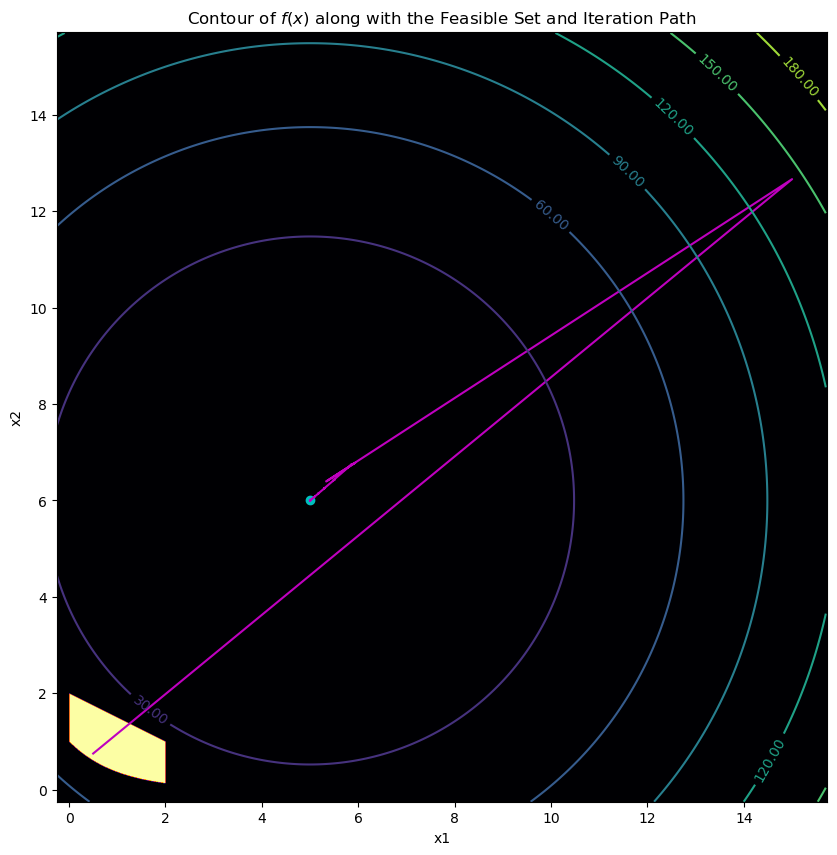

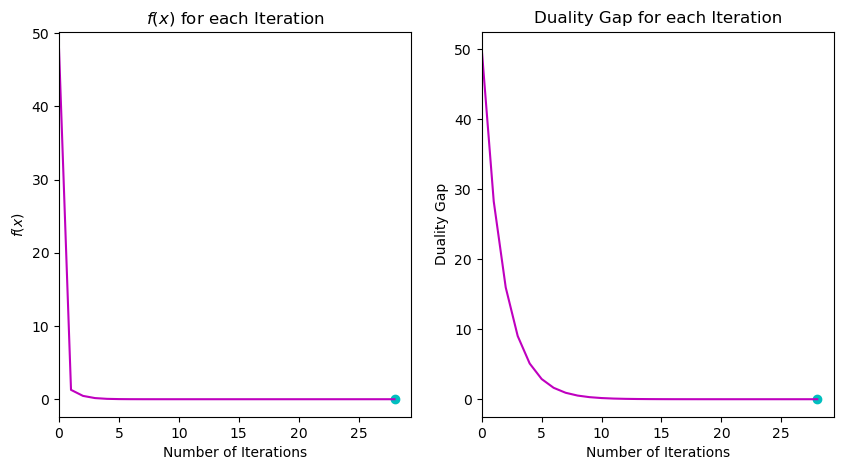

In [17]:
x_init = np.array([0.50, 0.75])
xs, fs, duality_gap = BarrierMethod(x_init, 5, 0.1)
plot_all(xs, fs, duality_gap)

In [18]:
xs

array([[ 0.5       ,  0.75      ],
       [15.        , 12.66666667],
       [ 5.33333333,  6.39473684],
       [ 5.9375    ,  6.781893  ],
       [ 5.84210526,  6.73725728],
       [ 5.85585586,  6.74214176],
       [ 5.85384615,  6.7416041 ],
       [ 5.85413929,  6.74166325],
       [ 5.85409652,  6.74165674],
       [ 5.85410276,  6.74165746],
       [ 5.48275322,  6.41919765],
       [ 5.51545033,  6.44025548],
       [ 5.5123946 ,  6.43881597],
       [ 5.51267864,  6.43891408],
       [ 5.51265222,  6.43890739],
       [ 5.51265468,  6.43890784],
       [ 5.28976121,  6.24807833],
       [ 5.30197081,  6.25565517],
       [ 5.30127542,  6.25534552],
       [ 5.30131494,  6.25535816],
       [ 5.3013127 ,  6.25535764],
       [ 5.17030725,  6.14433259],
       [ 5.1746225 ,  6.14694061],
       [ 5.17447688,  6.14687827],
       [ 5.17448179,  6.14687976],
       [ 5.09862005,  6.08301897],
       [ 5.1000874 ,  6.08389052],
       [ 5.10005861,  6.0838785 ],
       [ 5.10005917,

In [19]:
import numpy as np

# Assuming you have a 1000x28x28 matrix called 'matrix'
matrix = np.random.random((1000, 28, 28))

# Printing each row
for i in range(matrix.shape[0]):
    print(f"Row {i+1}:")
    print(matrix[i].shape)
    print()




Row 1:
(28, 28)

Row 2:
(28, 28)

Row 3:
(28, 28)

Row 4:
(28, 28)

Row 5:
(28, 28)

Row 6:
(28, 28)

Row 7:
(28, 28)

Row 8:
(28, 28)

Row 9:
(28, 28)

Row 10:
(28, 28)

Row 11:
(28, 28)

Row 12:
(28, 28)

Row 13:
(28, 28)

Row 14:
(28, 28)

Row 15:
(28, 28)

Row 16:
(28, 28)

Row 17:
(28, 28)

Row 18:
(28, 28)

Row 19:
(28, 28)

Row 20:
(28, 28)

Row 21:
(28, 28)

Row 22:
(28, 28)

Row 23:
(28, 28)

Row 24:
(28, 28)

Row 25:
(28, 28)

Row 26:
(28, 28)

Row 27:
(28, 28)

Row 28:
(28, 28)

Row 29:
(28, 28)

Row 30:
(28, 28)

Row 31:
(28, 28)

Row 32:
(28, 28)

Row 33:
(28, 28)

Row 34:
(28, 28)

Row 35:
(28, 28)

Row 36:
(28, 28)

Row 37:
(28, 28)

Row 38:
(28, 28)

Row 39:
(28, 28)

Row 40:
(28, 28)

Row 41:
(28, 28)

Row 42:
(28, 28)

Row 43:
(28, 28)

Row 44:
(28, 28)

Row 45:
(28, 28)

Row 46:
(28, 28)

Row 47:
(28, 28)

Row 48:
(28, 28)

Row 49:
(28, 28)

Row 50:
(28, 28)

Row 51:
(28, 28)

Row 52:
(28, 28)

Row 53:
(28, 28)

Row 54:
(28, 28)

Row 55:
(28, 28)

Row 56:
(28, 28)

R

In [ ]:
import torch

# Given samples
samples = [-5.0000, -4.8859, -4.7718, -4.6577, -4.5436, -4.4295, -4.3154, -4.2013, -4.0872, -3.9732, -3.8591, -3.7450, -3.6309, -3.5168, -3.4027, -3.2886, -3.1745, -3.0604, -2.9463, -2.8322, -2.7181, -2.6040, -2.4899, -2.3758, -2.2617, -2.1477, -2.0336, -1.9195, -1.8054, -1.6913, -1.5772, -1.4631, -1.3490, -1.2349, -1.1208, -1.0067, -0.8926, -0.7785, -0.6644, -0.5503, -0.4362, -0.3221, -0.2081, -0.0940, 0.0201, 0.1342, 0.2483, 0.3624, 0.4765, 0.5906, 0.7047, 0.8188, 0.9329, 1.0470, 1.1611, 1.2752, 1.3893, 1.5034, 1.6174, 1.7315, 1.8456, 1.9597, 2.0738, 2.1879, 2.3020, 2.4161, 2.5302, 2.6443, 2.7584, 2.8725, 2.9866, 3.1007, 3.2148, 3.3289, 3.4430, 3.5570, 3.6711, 3.7852, 3.8993, 4.0134, 4.1275, 4.2416, 4.3557, 4.4698, 4.5839, 4.6980, 4.8121, 4.9262, 5.0403, 5.1544, 5.2685, 5.3826, 5.4966, 5.6107, 5.7248, 5.8389, 5.9530, 6.0671, 6.1812]

# Convert samples to PyTorch tensor
samples_tensor = torch.tensor(samples)

# Print the tensor
print(samples_tensor)